In [1]:
import numpy as np
from scipy.integrate import odeint
# import matplotlib.pyplot as plt
from matplotlib import pyplot as PLT
import math
import pandas as pd

import sympy as sm

In [2]:
def RSteadyState(N,I):
    return (alpha + c*N) / (b_R - epsilon*a*I)
def NSteadyState(R):
    return (mu + (R/kA)**n) / ((c + c*(R/kA)**n + g + g*(R/kA)**n + beta))                               
def TSteadyState(N,I,R):
    return (-1 * beta * N) / (a*I + a*I*(R/kA)**n - b_T - b_T * (R/kA)**n)
def ISteadyState(T,R):
    return (d*T) / (e_T*T + e_R*R + f)

In [3]:
#function that returns dy/dt
def modelNew(ic,t,co):
    # Initial conditions
    N = ic[0] #N = naive T-cells
    T = ic[1] #T = Activated T-cells
    I = ic[2] #I = IL-2
    R = ic[3] #R = TRegs
    
    # Constant Values
    alpha   = co[0]
    Thy     = co[1]
    Thy_max = co[2]   
    epsilon = co[3]
    a       = co[4]
    c       = co[5]
    b_R     = co[6]
    mu      = co[7]
    beta    = co[8]
    z       = co[9]
    g       = co[10]
    b_T     = co[11]
    d       = co[12]
    e_T     = co[13]
    e_R     = co[14]
    f       = co[15]
    
    #New parameters
    kA      = co[16]
    n       = co[17];
    

    
    dRdt = alpha*(Thy/Thy_max) + epsilon*a*I*R + c*N - b_R*R
    dNdt = mu*(Thy/Thy_max) - beta*N*(1/(1+(R/kA)**n)) - c*N - g*N 
    dTdt = beta*N*(1/(1+(R/kA)**n)) + a*I*T - b_T*T
    dIdt = d*T - e_T*I*T - e_R*I*R - f*I
    
    
    return [dNdt, dTdt, dIdt, dRdt]

In [7]:
############
#  Thymus  #
############
alpha = 0.006 #------------ T Regulatory Cells
mu = 3000 #60  #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus

#########################################
#  Naive T cell Differentiation Rates   #
#########################################
c = 0.01 #--------To T regulatory Cells
beta = 10 #------ To activated T cells

###########
#  Tregs  #
###########
epsilon = 1 #------------T regulatory cell Self replication
z       = 1 #------- Strength of suppression on Naive T cell differention to activation
n       = 1 #hill coefficient
kA      = 70# 10 #halfSaturationRate 

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
d = 0.01 #------- T Cell Expression
a = 0.1   #------------Activated T cells
e_T = 0.01 #------ T Cell Consumption Rate
e_R = 0.01 #------ T Reg Consumption Rate

##################
#  Death Rates   #
##################
g = 0.01 #-----------Naive T cells
b_T = 0.1 #-----------Activated T cells
b_R = 0.1 #----------Regulatory T Cells
f = 1 #-------------IL-2 Cytokine

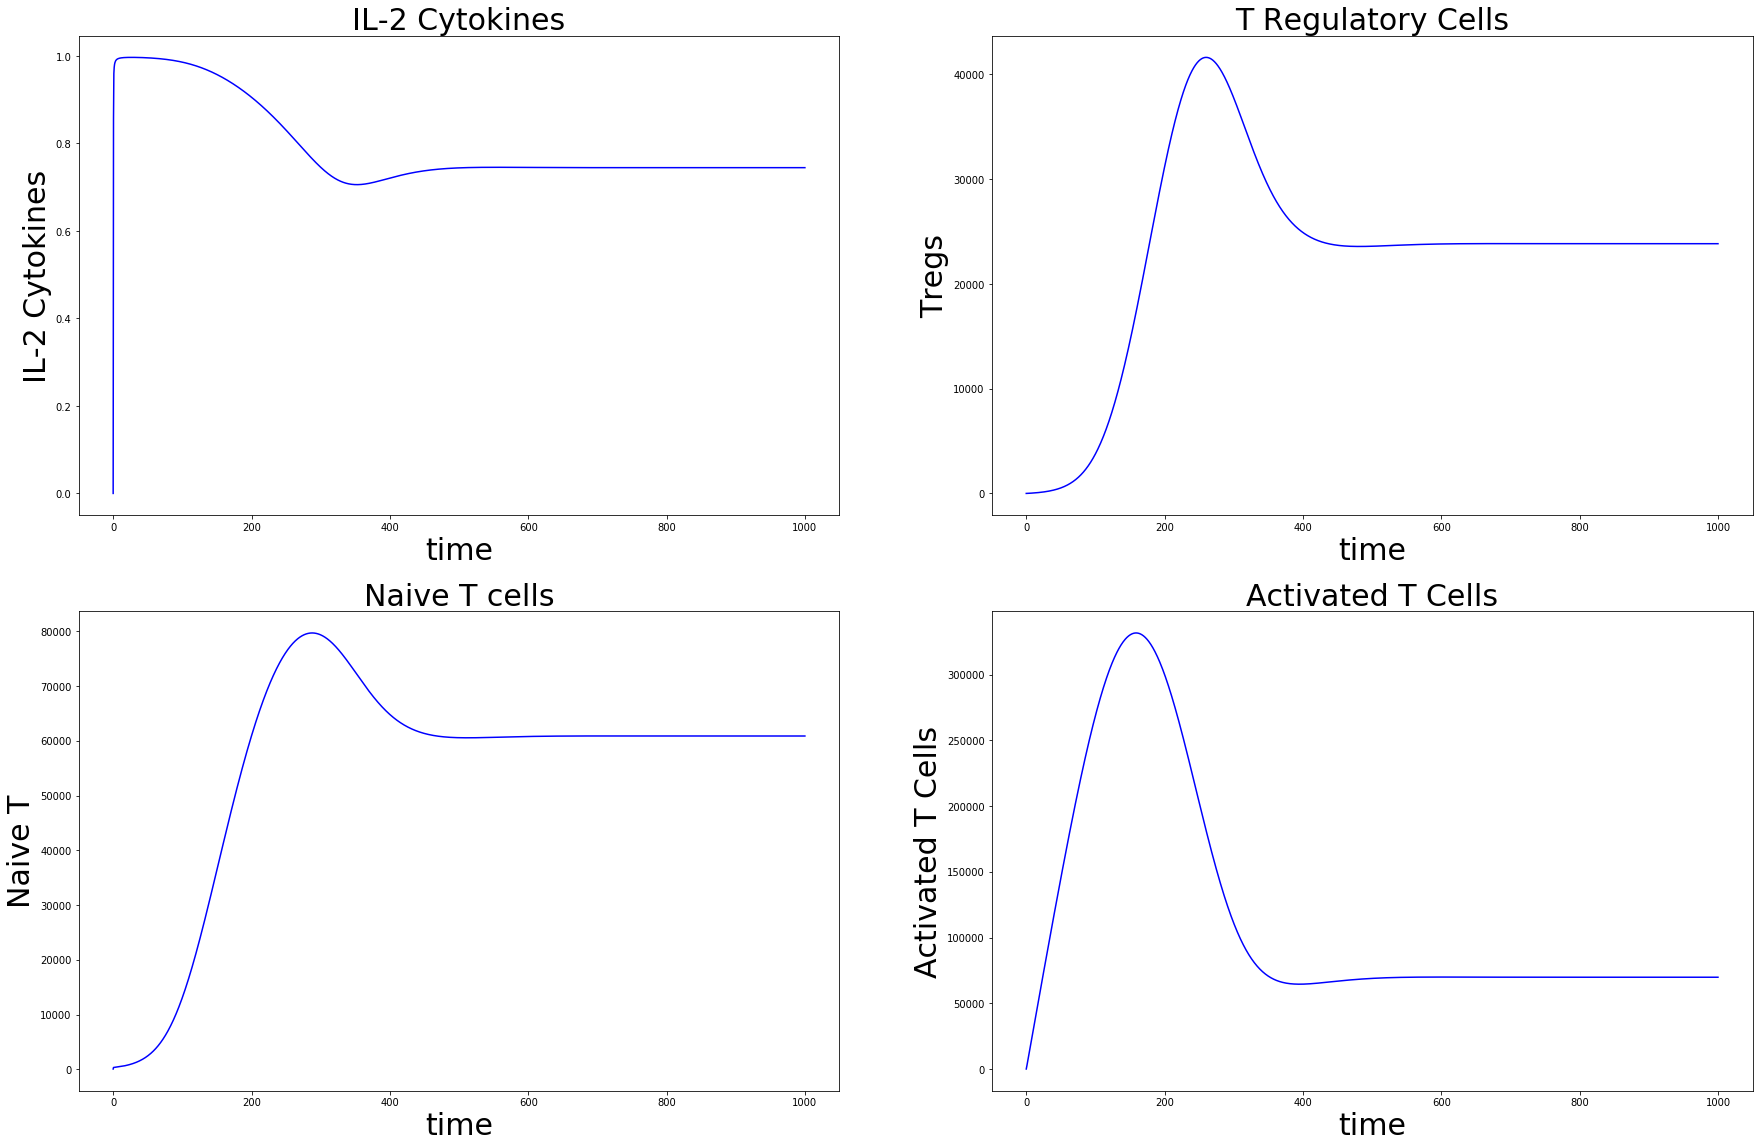

In [9]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 2000;
t = np.linspace(0,1000,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,0,0,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

In [6]:
#Treg Freq
Cells['TregFreq'] = Cells['R'] / (Cells['N']+Cells['T'])
PLT.plot(Cells['time'], Cells['TregFreq'])

NameError: name 'Cells' is not defined

In [7]:
R,N,T,I = sm.symbols('R,N,T,I',negative=False)

n = 1;
    
dRdt = alpha + epsilon*a*I*R + c*N - b_R*R
dNdt = mu - beta*N*(1/(1+(R/kA)**n)) - c*N - g*N 
dTdt = beta*N*(1/(1+(R/kA)**n)) + a*I*T - b_T*T
dIdt = d*T - e_T*I*T - e_R*I*R - f*I
    
REqual = sm.Eq(dRdt,0)
NEqual = sm.Eq(dNdt,0)
TEqual = sm.Eq(dTdt,0)
IEqual = sm.Eq(dIdt,0)

equilibria = sm.solve((REqual,NEqual,TEqual,IEqual),R,N,T,I)

print(equilibria)

[(-5288.73921629165 + 0.e-19*I, 56813.7410284786 - 0.e-18*I, 10018.8381102587 - 0.e-19*I, 2.07425113443796 + 0.e-20*I), (-0.130307415903954 - 0.e-23*I, 5.91014927915535 + 0.e-22*I, -119.859651354203 + 0.e-19*I, 5.99599292487988 - 0.e-21*I), (478.929523707555 + 0.e-17*I, 267.226708739359 + 0.e-19*I, 9773.52719558586 - 0.e-19*I, 0.944078054185087 + 0.e-22*I)]


In [8]:
-5288.73921629165 + 0.e-19*I, 56813.7410284786 - 0.e-18*I, 10018.8381102587 - 0.e-19*I, 2.07425113443796 + 0.e-20*I

(-5288.73921629165, 56813.7410284786, 10018.8381102587, 2.07425113443796)

In [12]:
-0.130307415903954 - 0.e-23*I, 5.91014927915535 + 0.e-22*I, -119.859651354203 + 0.e-19*I, 5.99599292487988 - 0.e-21*I

(-0.130307415903954, 5.91014927915535, -119.859651354203, 5.99599292487988)

In [11]:
(478.929523707555 + 0.e-17*I, 267.226708739359 + 0.e-19*I, 9773.52719558586 - 0.e-19*I, 0.944078054185087 + 0.e-22*I)

(478.929523707555, 267.226708739359, 9773.52719558586, 0.944078054185087)

In [15]:
0.e-17

0.0

In [17]:
import sympy as sm

r,c = sm.symbols('r,c',negative=False)
R = 2*r - r**2 - r*c
C = -c + r*c

REqual = sm.Eq(R,0)
CEqual = sm.Eq(C,0)

equilibria = sm.solve((REqual,CEqual),r,c)
print(equilibria)

[(0, 0), (1, 1), (2, 0)]


In [36]:
epsilon * a *0.4

0.04000000000000001

In [20]:
co

[0.006,
 1,
 1,
 1,
 0.1,
 0.01,
 0.1,
 60,
 10,
 1,
 0.01,
 0.1,
 0.01,
 0.01,
 0.01,
 1,
 10,
 1]

In [ ]:
#Starting parameters
# co = [0.006, 1, 1, 1, 0.1, 0.01, 0.1, 4, 10, 0.6, 0.01, 0.1, 0.01, 0.01, 0.01, 1]
#A wiggle!
# co = [0.006, 1, 1, 1, 0.1, 0.01, 0.1, 60, 10, 1, 0.01, 0.1, 0.01, 0.01, 0.01, 1, 10, 1]

In [19]:
############
#  Thymus  #
############
alpha = 0.006 #------------ T Regulatory Cells
mu = 60  #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus

#########################################
#  Naive T cell Differentiation Rates   #
#########################################
c = 0.01 #--------To T regulatory Cells
beta = 10 #------ To activated T cells

###########
#  Tregs  #
###########
epsilon = 1 #------------T regulatory cell Self replication
z       = 1 #------- Strength of suppression on Naive T cell differention to activation
n       = 1 #hill coefficient
kA      = 70# 10 #halfSaturationRate 

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
d = 0.01 #------- T Cell Expression
a = 0.1   #------------Activated T cells
e_T = 0.01 #------ T Cell Consumption Rate
e_R = 0.01 #------ T Reg Consumption Rate

##################
#  Death Rates   #
##################
g = 0.01 #-----------Naive T cells
b_T = 0.1 #-----------Activated T cells
b_R = 0.1 #----------Regulatory T Cells
f = 1 #-------------IL-2 Cytokine

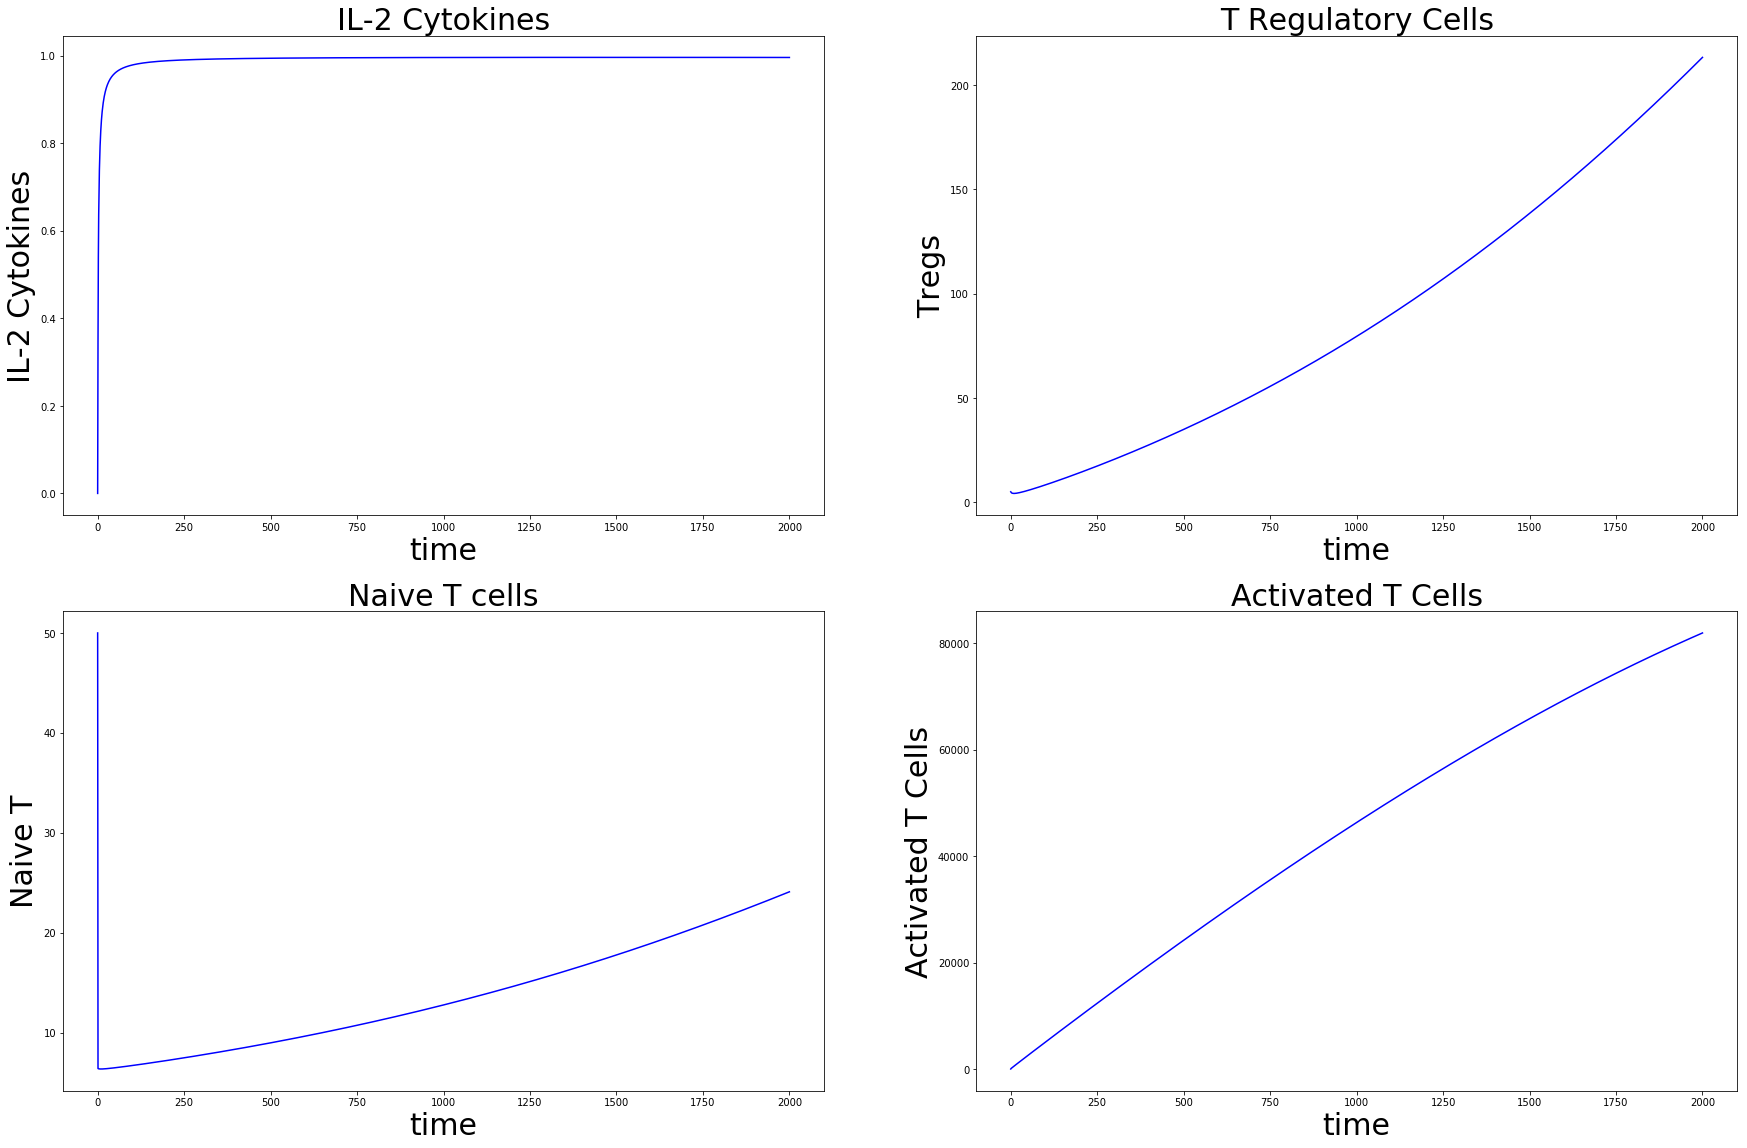

In [22]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 2000;
t = np.linspace(0,2000,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,0,0,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

In [23]:
############
#  Thymus  #
############
alpha = 0.006 #------------ T Regulatory Cells
mu = 60  #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus

#########################################
#  Naive T cell Differentiation Rates   #
#########################################
c = 0.01 #--------To T regulatory Cells
beta = 10 #------ To activated T cells

###########
#  Tregs  #
###########
epsilon = 1 #------------T regulatory cell Self replication
z       = 1 #------- Strength of suppression on Naive T cell differention to activation
n       = 1 #hill coefficient
kA      = 10 #halfSaturationRate 

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
d = 0.01 #------- T Cell Expression
a = 0.1   #------------Activated T cells
e_T = 0.01 #------ T Cell Consumption Rate
e_R = 0.01 #------ T Reg Consumption Rate

##################
#  Death Rates   #
##################
g = 0.01 #-----------Naive T cells
b_T = 0.1 #-----------Activated T cells
b_R = 0.1 #----------Regulatory T Cells
f = 1 #-------------IL-2 Cytokine

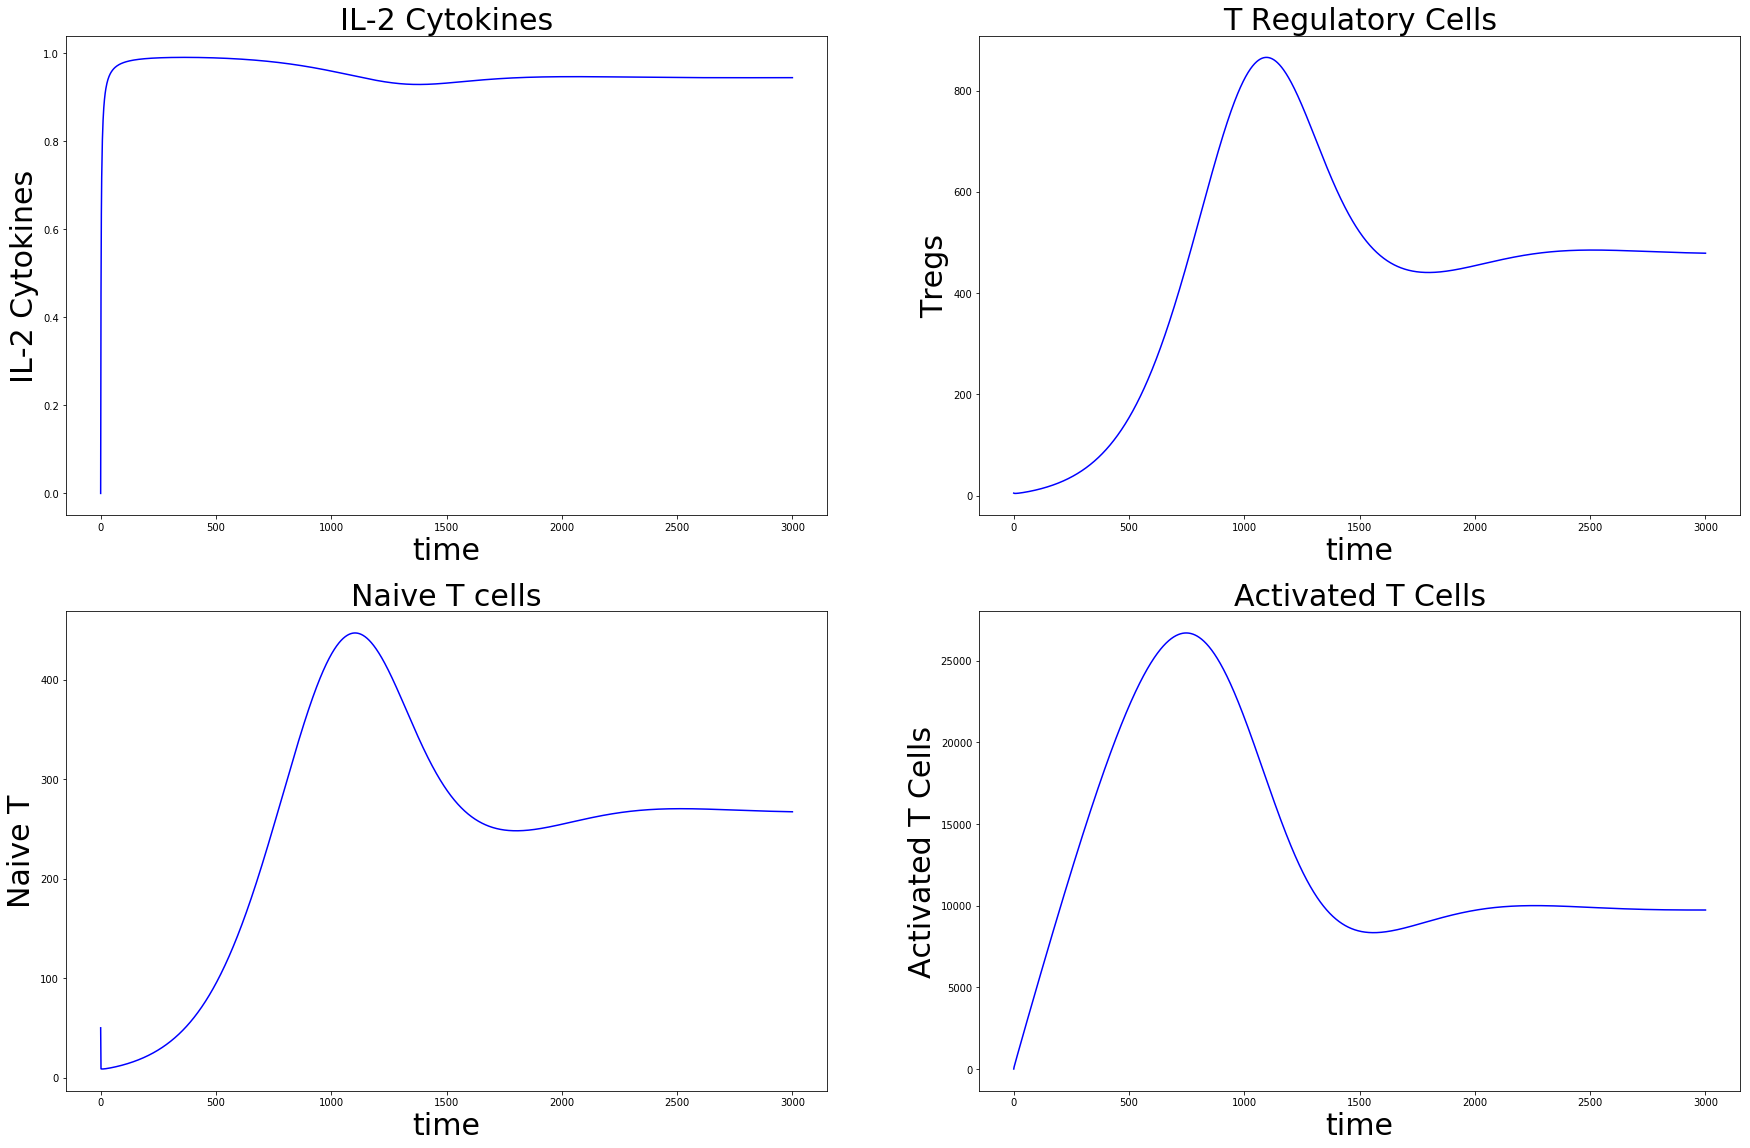

In [24]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 2000;
t = np.linspace(0,3000,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,0,0,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

In [30]:
############
#  Thymus  #
############
alpha = 0.006 #------------ T Regulatory Cells
mu = 60  #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus

#########################################
#  Naive T cell Differentiation Rates   #
#########################################
c = 0.01 #--------To T regulatory Cells
beta = 10 #------ To activated T cells

###########
#  Tregs  #
###########
epsilon = 1 #------------T regulatory cell Self replication
z       = 1 #------- Strength of suppression on Naive T cell differention to activation
n       = 1 #hill coefficient
kA      = 10 #halfSaturationRate 

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
d = 0.03 #------- T Cell Expression
a = 0.1   #------------Activated T cells
e_T = 0.03 #------ T Cell Consumption Rate
e_R = 0.03 #------ T Reg Consumption Rate

##################
#  Death Rates   #
##################
g = 0.01 #-----------Naive T cells
b_T = 0.1 #-----------Activated T cells
b_R = 0.1 #----------Regulatory T Cells
f = 1 #-------------IL-2 Cytokine

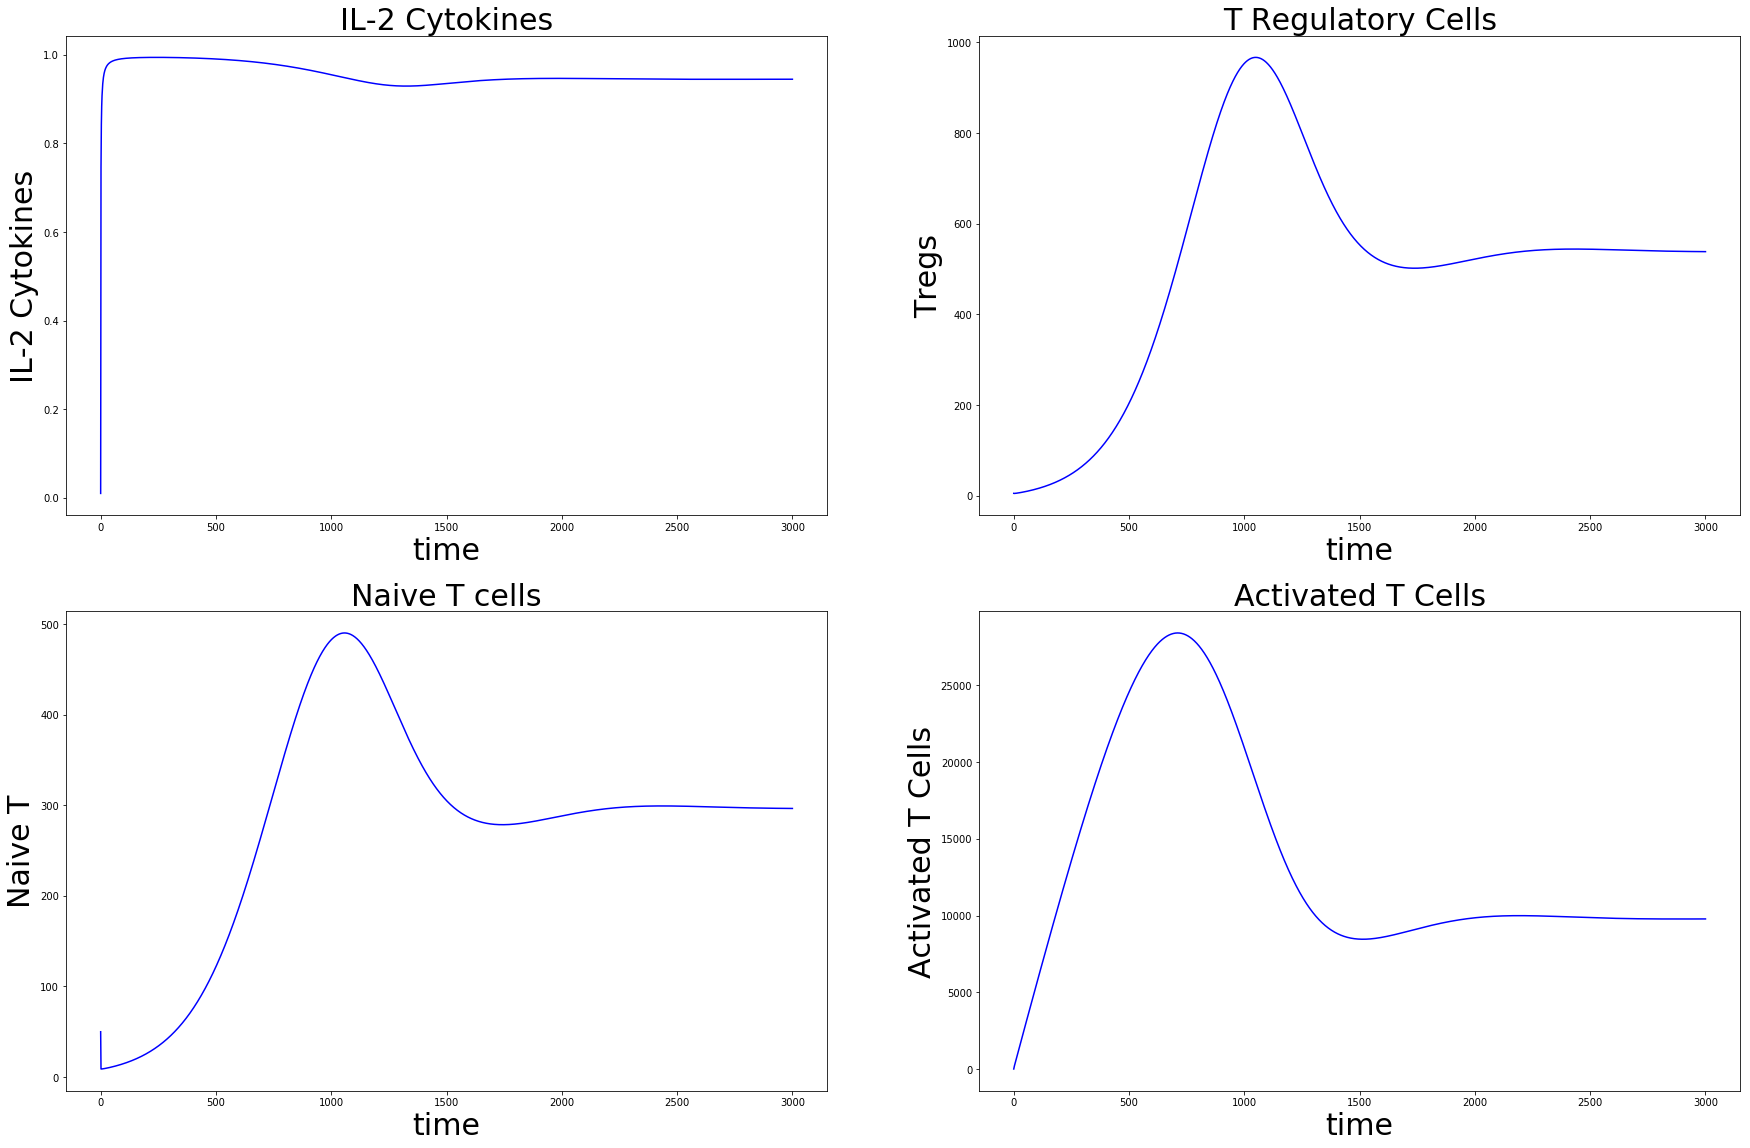

In [31]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 2000;
t = np.linspace(0,3000,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,2,0.01,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

In [ ]:
# Treg conversion might need to be changed, because there will be a lot more naive T cells than before, so right now,
# 1% of naive T cells get converted. I should figure out this parameter from that paper I have been wanting to read.

# I should probably keep death rates as a percentage per day as well
# 43/254 - 17%

In [3]:
############
#  Thymus  #
############
alpha = 18 #------------ T Regulatory Cells
mu = 254  #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus

#########################################
#  Naive T cell Differentiation Rates   #
#########################################
c = 0.01 #--------To T regulatory Cells
beta = 0.17 #------ To activated T cells

###########
#  Tregs  #
###########
epsilon = 1 #------------T regulatory cell Self replication
z       = 1 #------- Strength of suppression on Naive T cell differention to activation
n       = 1 #hill coefficient
kA      = 10 #halfSaturationRate 

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
d = 0.03 #------- T Cell Expression
a = 0.1   #------------Activated T cells
e_T = 0.03 #------ T Cell Consumption Rate
e_R = 0.03 #------ T Reg Consumption Rate

##################
#  Death Rates   #
##################
g =  0.01 #-----------Naive T cells
b_T = 0.1 #-----------Activated T cells
b_R = 0.1 #----------Regulatory T Cells
f = 1 #-------------IL-2 Cytokine

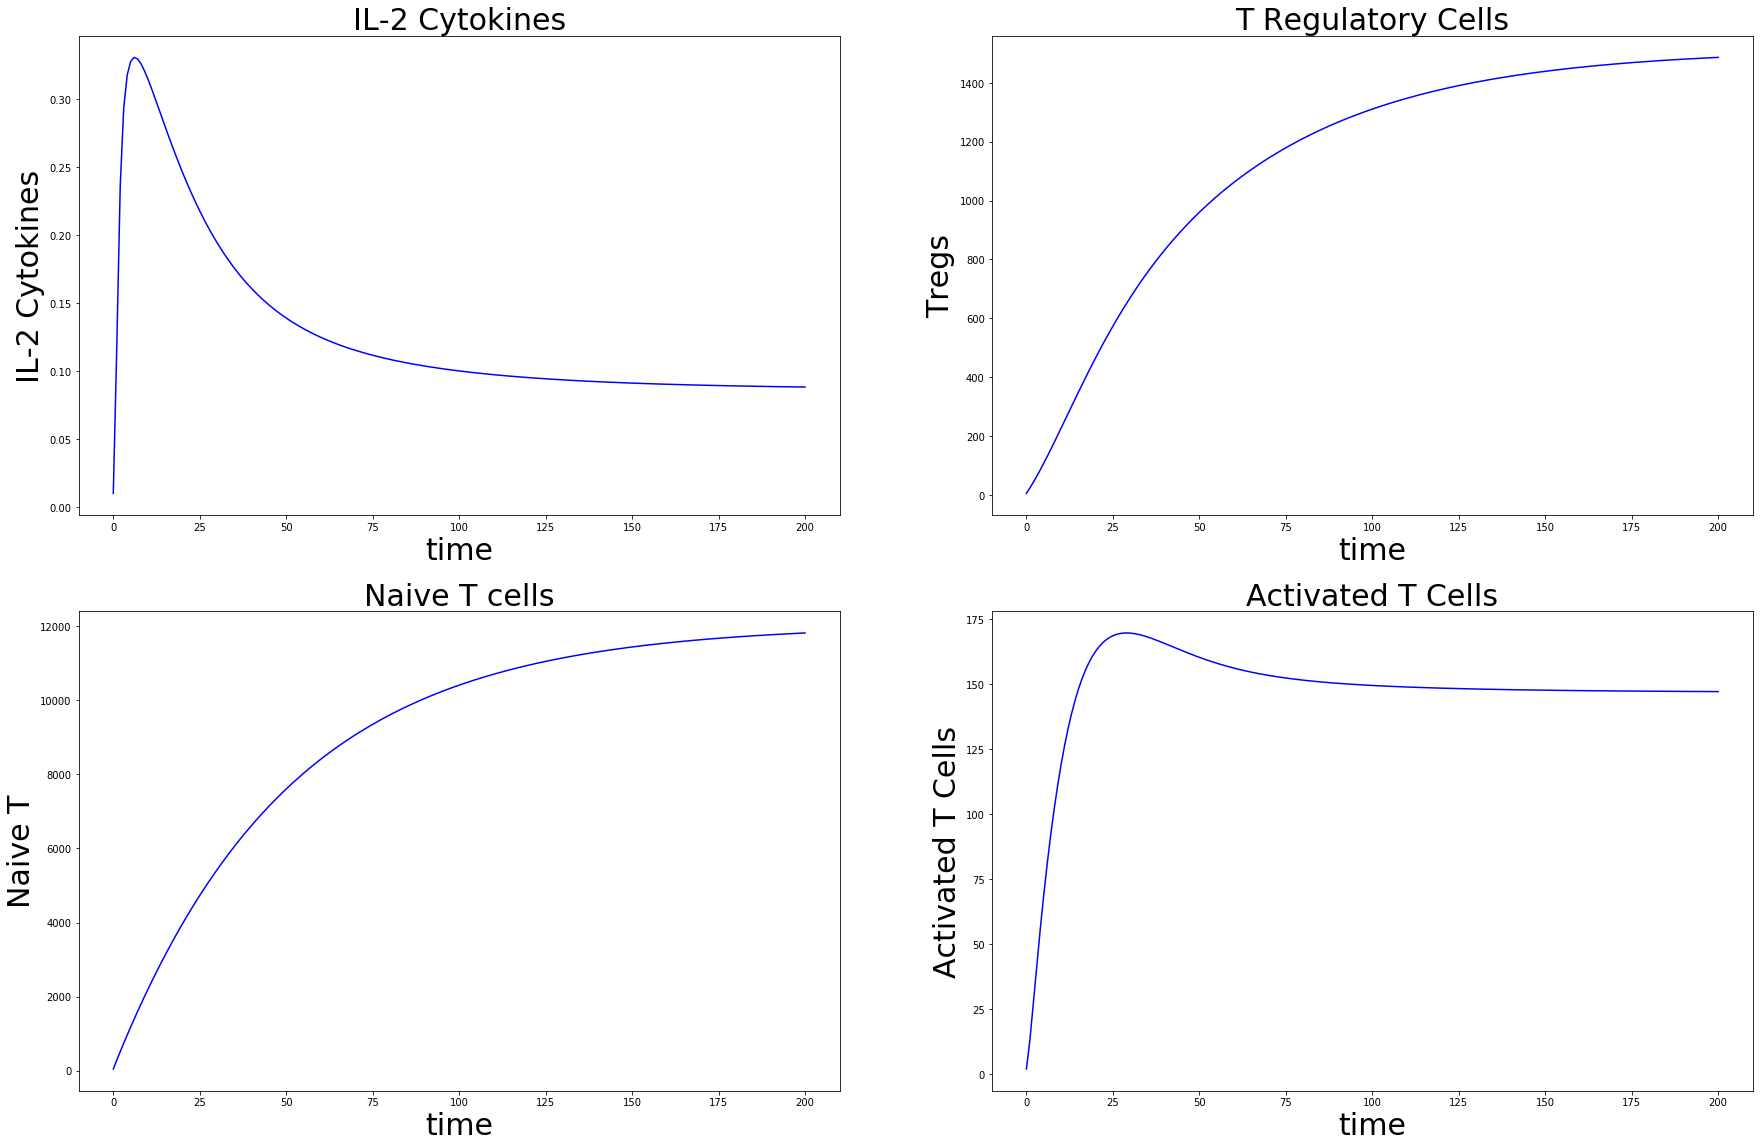

In [18]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 200;
t = np.linspace(0,numTime,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,2,0.01,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

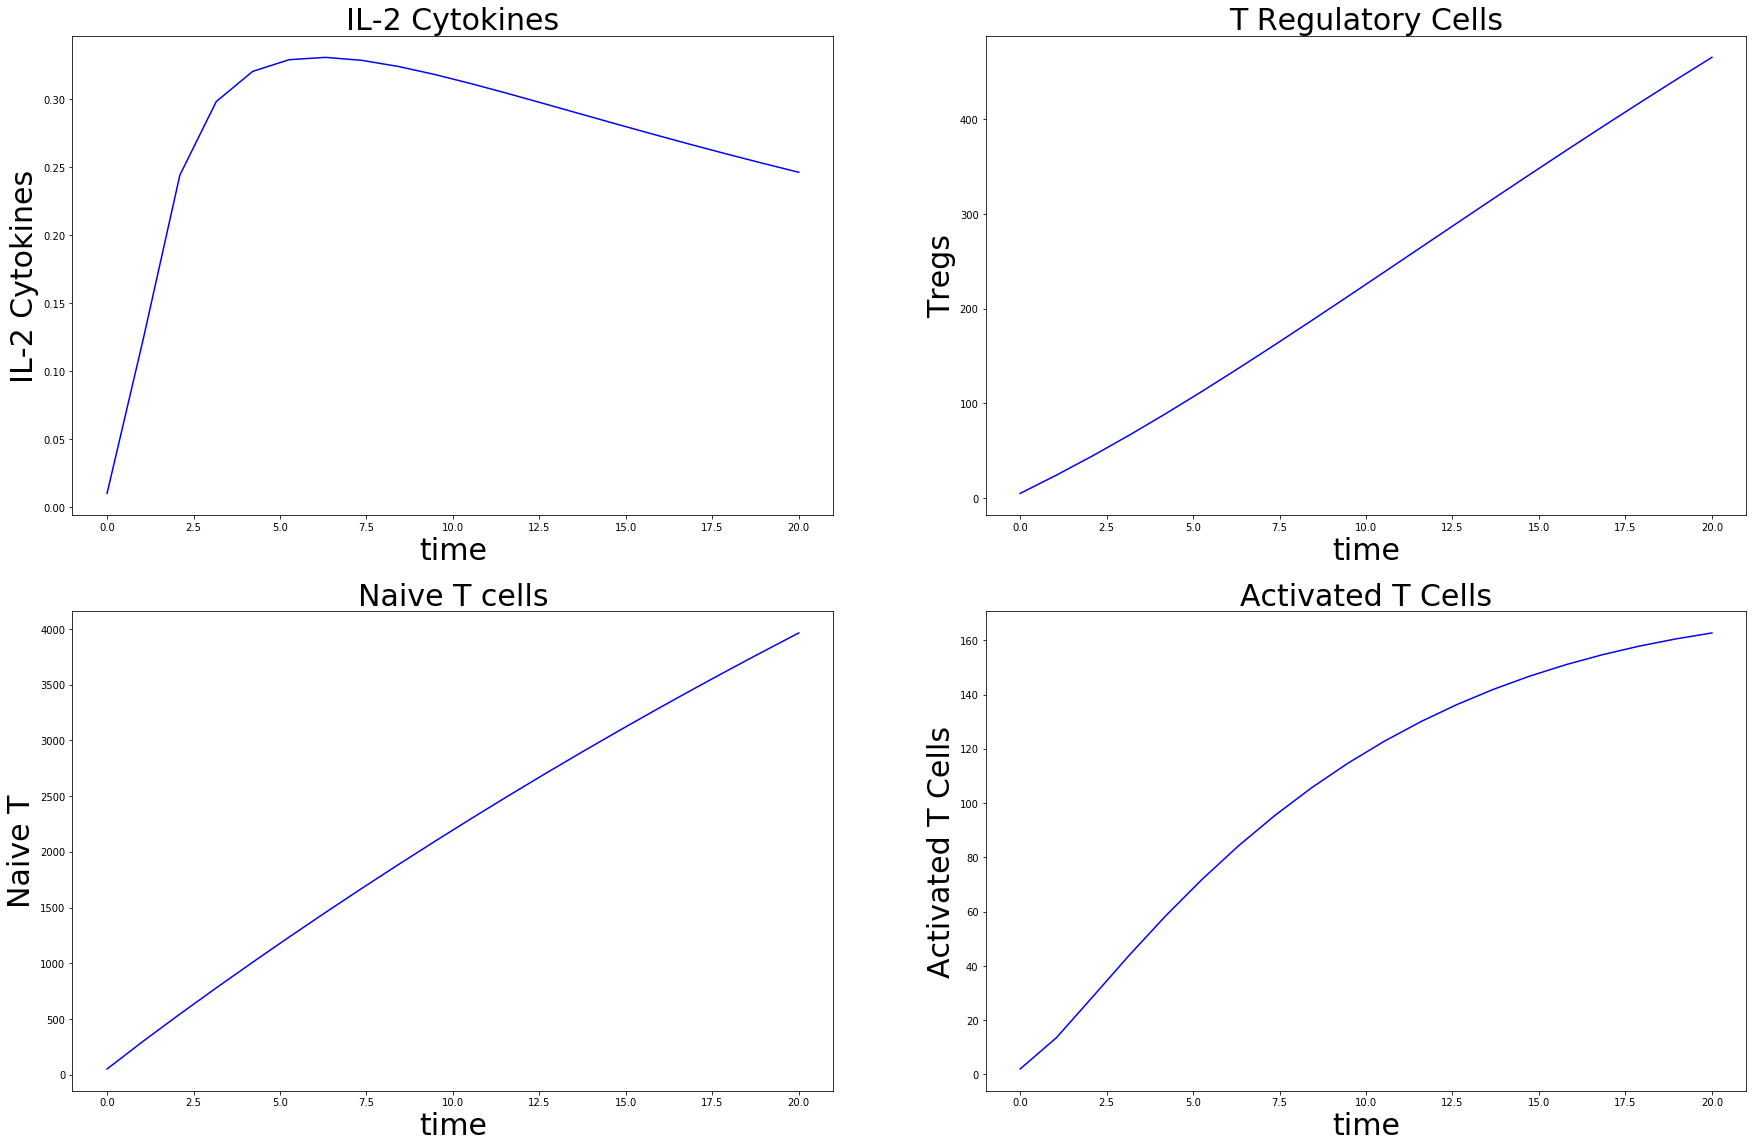

In [19]:
#Constants are saved in a array that is fed to the odeint function
co = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f,kA,n]

# time points
#t = np.linspace(0,10)
numTime = 20;
t = np.linspace(0,numTime,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [50,2,0.01,5]

# solve ODE
dyn = odeint(modelNew,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

fig = PLT.figure(figsize=(30,30))
#Naive
ax1 = fig.add_subplot(323)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
# ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time', fontsize = 30)
ax1.set_ylabel('Naive T', fontsize = 30)
ax1.set_title('Naive T cells', fontsize = 30)
# T
ax2 = fig.add_subplot(324)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time', fontsize = 30)
ax2.set_ylabel('Activated T Cells', fontsize = 30)
ax2.set_title('Activated T Cells', fontsize = 30)
# Tregs
ax4 = fig.add_subplot(322)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time', fontsize = 30)
ax4.set_ylabel('Tregs', fontsize = 30)
ax4.set_title('T Regulatory Cells', fontsize = 30)
# IL-2
ax3 = fig.add_subplot(321)
ax3.plot(Cells['time'],Cells['I'],'b-')
# ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time', fontsize = 30)
ax3.set_ylabel('IL-2 Cytokines', fontsize = 30)
ax3.set_title('IL-2 Cytokines', fontsize = 30)
# # IL-2 vs T
# ax5 = fig.add_subplot(325)
# ax5.plot(Cells['I'],Cells['T'],'b-')
# ax5.set_xlabel('IL-2 Cytokines')
# ax5.set_ylabel('CD4 T cells')
# ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# # IL-2 vs. Tregs
# ax6 = fig.add_subplot(326)
# ax6.plot(Cells['I'],Cells['R'],'b-')
# ax6.set_xlabel('IL-2 Cytokines')
# ax6.set_ylabel('Tregs')
# ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()